<h1 align="center" style="color:#96d9f0;">Computational Intelligence for
Optimization - Project</h1>
<h3 align="center" style="color:#96d9f0;">Group AW - Wedding Seating Optimization</h3>

---

### <span style="color:#96d9f0;">Group Members</span>

<table>
  <thead style="color:#96d9f0;">
    <tr>
      <th>Name</th>
      <th>Email</th>
      <th>Student ID</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Afonso Dias</td>
      <td>20211540@novaims.unl.pt</td>
      <td>20211540</td>
    </tr>
    <tr>
      <td>Isabel Duarte</td>
      <td>20240545@novaims.unl.pt</td>
      <td>20240545</td>
    </tr>
    <tr>
      <td>Pedro Campino</td>
      <td>20240537@novaims.unl.pt</td>
      <td>20240537</td>
    </tr>
    <tr>
      <td>Rita Matos</td>
      <td>20211642@novaims.unl.pt</td>
      <td>20211642</td>
    </tr>
  </tbody>
</table>

---

### <span style="color:#96d9f0;">1. Imports</span>

This section includes all the necessary library imports required for the development of the project. We also use the library provided during the practical classes, as recommended, to support the implementation. Additionally, the relationship matrix used for evaluating guest compatibility is imported here.

In [9]:
import sys
sys.path.append('..')

In [11]:
import random
from copy import deepcopy
from library.solution import Solution
import csv
import os
import pandas as pd
import numpy as np
from itertools import combinations
from typing import Callable

from tqdm import tqdm
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt



from library.algorithms.simulated_annealing import simulated_annealing
from library.algorithms.genetic_algorithms.algorithm import get_best_ind
from library.solution import Solution
from library.solution import WSSolution

ImportError: cannot import name 'WSSolution' from 'library.solution' (c:\Users\35191\Desktop\Nova IMS\Master's\1st Year\2nd Semester\Computational Intelligence for Optimization\Project\CIFO-Project\library\solution.py)

In [ ]:
# Import the relationship matrix as a pandas dataframe for visualization

relationship_matrix_df = pd.read_csv('data/seating_data.csv')
relationship_matrix_df.drop(columns='idx', inplace=True)
relationship_matrix_df

,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
0,0,5000,0,0,700,700,0,0,0,0,...,100,100,0,0,100,100,100,0,0,0
1,5000,0,700,700,0,0,300,300,500,500,...,100,100,0,100,0,0,0,0,0,0
2,0,700,0,2000,0,0,0,0,300,300,...,0,0,0,0,0,0,0,0,0,0
3,0,700,2000,0,0,0,900,400,300,300,...,0,0,0,0,0,0,0,0,0,0
4,700,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,100,0,0,2000,700,700
61,0,0,0,0,0,0,0,0,0,0,...,0,0,-1000,0,100,0,2000,0,700,700
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,700,700,0,900


In [ ]:
# Import the relationship matrix as a numpy array

relationship_matrix = np.loadtxt('data/seating_data.csv', delimiter=',', skiprows=1)
relationship_matrix = relationship_matrix[ : , 1:]
relationship_matrix 

array([[   0., 5000.,    0., ...,    0.,    0.,    0.],
       [5000.,    0.,  700., ...,    0.,    0.,    0.],
       [   0.,  700.,    0., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,  700.,  700.],
       [   0.,    0.,    0., ...,  700.,    0.,  900.],
       [   0.,    0.,    0., ...,  700.,  900.,    0.]], shape=(64, 64))

---

### <span style="color:#96d9f0;">2. Solution Representation</span>

In this section, we define the Wedding Sitting Solution class (`WSSolution`), which extends the base `Solution` class provided in the practical classes. This class represents a candidate solution for the wedding seating optimization problem.

Each solution consists of a list of tables, where each table is a list of guest indices. The class includes methods to generate a valid random initial representation and to evaluate the fitness of a solution based on the total relationship scores between guests seated at the same table.

In [32]:
class WSSearchableSolution(WSSolution):
    def get_neighbors(self):
        """Generates all valid neighbors by swapping two guests between tables."""
        neighbors = []

        # Loop through all pairs of guests at different tables
        for i in range(len(self.repr)):
            for j in range(len(self.repr[i])):
                for k in range(len(self.repr)):
                    for l in range(len(self.repr[k])):
                        if (i, j) != (k, l):  # Skip swapping guests at the same position
                            new_seating = deepcopy(self.repr)  # Use `repr` which holds the seating
                            new_seating[i][j], new_seating[k][l] = new_seating[k][l], new_seating[i][j]

                            # Create a new WSSearchableSolution with the modified seating arrangement
                            neighbor = WSSearchableSolution(
                                repr=new_seating,
                                relationship_matrix=self.relationship_matrix,  # Use relationship_matrix
                                nr_of_tables=self.nr_of_tables
                            )
                            neighbors.append(neighbor)

        return neighbors

    def get_random_neighbor(self):
        """Generates a random valid neighbor by swapping two guests between different tables."""
        new_seating = deepcopy(self.repr)  # Use `repr` for seating arrangement

        # Randomly pick two different tables
        table_indices = list(range(len(new_seating)))
        t1, t2 = random.sample(table_indices, 2)

        # Make sure the tables are not empty
        if not new_seating[t1] or not new_seating[t2]:
            return deepcopy(self)

        # Randomly pick a guest from each table
        g1 = random.randrange(len(new_seating[t1]))
        g2 = random.randrange(len(new_seating[t2]))

        # Swap the guests
        new_seating[t1][g1], new_seating[t2][g2] = new_seating[t2][g2], new_seating[t1][g1]

        return WSSearchableSolution(
            repr=new_seating,
            relationship_matrix=self.relationship_matrix,  # Use relationship_matrix
            nr_of_tables=self.nr_of_tables
        )

In [36]:
# Create a random seating arrangement using WSSolution
initial_solution = WSSolution(relationship_matrix=relationship_matrix, nr_of_tables=8)
seating = initial_solution.random_initial_representation()

# Print initial seating and fitness
print("Initial Seating Arrangement:", seating)
print("Initial Fitness:", initial_solution.fitness())

# Create a searchable solution
searchable_solution = WSSearchableSolution(
    repr=seating,
    relationship_matrix=relationship_matrix,
    nr_of_tables=8
)

# Generate neighbors and print the number of neighbors
neighbors = searchable_solution.get_neighbors()
print(f"Generated {len(neighbors)} neighbors.")

# Test random neighbor generation
random_neighbor = searchable_solution.get_random_neighbor()
print("Random Neighbor Seating:", random_neighbor.repr)
print("Random Neighbor Fitness:", random_neighbor.fitness())

Initial Seating Arrangement: [[9, 48, 23, 38, 8, 35, 33, 45], [55, 59, 1, 28, 46, 3, 54, 13], [60, 27, 16, 17, 20, 41, 44, 6], [58, 4, 31, 2, 52, 37, 11, 14], [29, 22, 62, 43, 19, 51, 40, 0], [61, 36, 21, 5, 50, 47, 34, 10], [56, 39, 42, 57, 49, 18, 53, 30], [24, 25, 7, 63, 26, 12, 32, 15]]
Initial Fitness: 5600.0
Generated 4032 neighbors.
Random Neighbor Seating: [[9, 48, 23, 63, 8, 35, 33, 45], [55, 59, 1, 28, 46, 3, 54, 13], [60, 27, 16, 17, 20, 41, 44, 6], [58, 4, 31, 2, 52, 37, 11, 14], [29, 22, 62, 43, 19, 51, 40, 0], [61, 36, 21, 5, 50, 47, 34, 10], [56, 39, 42, 57, 49, 18, 53, 30], [24, 25, 7, 38, 26, 12, 32, 15]]
Random Neighbor Fitness: 12700.0


# Hill Climbing

In [ ]:
def hill_climbing(initial_solution: Solution, maximization=False, max_iter=99999, verbose=False):
    """
    Implementation of the Hill Climbing optimization algorithm.  

    The algorithm iteratively explores the neighbors of the current solution, moving to a neighbor if it improves the objective function.  
    The process continues until no improvement is found or the maximum number of iterations is reached.  

    Args:
        initial_solution (Solution): The starting solution, which must implement the `fitness()` and `get_neighbors()` methods.
        maximization (bool, optional): If True, the algorithm maximizes the fitness function; otherwise, it minimizes it. Defaults to False.
        max_iter (int, optional): The maximum number of iterations allowed before stopping. Defaults to 99,999.
        verbose (bool, optional): If True, prints progress details during execution. Defaults to False.

    Returns:
        Solution: The best solution found during the search.

    Notes:
        - The initial_solution must implement a `fitness()` and `get_neighbors()` method.
        - The algorithm does not guarantee a global optimum; it only finds a local optimum.
    """

    # Run some validations to make sure initial solution is well implemented
    run_validations(initial_solution)

    current = initial_solution
    improved = True
    iter = 1

    while improved:
        if verbose:
            print(f'Current solution: {current} with fitness {current.fitness()}')

        improved = False
        neighbors = current.get_neighbors() # Solution must have a get_neighbors() method

        for neighbor in neighbors:

            if verbose:
                print(f'Neighbor: {neighbor} with fitness {neighbor.fitness()}')

            if maximization and (neighbor.fitness() > current.fitness()):
                current = deepcopy(neighbor)
                improved = True
            elif not maximization and (neighbor.fitness() <= current.fitness()):
                current = deepcopy(neighbor)
                improved = True
        
        iter += 1
        if iter == max_iter:
            break
    
    return current

def run_validations(initial_solution):
    if not isinstance(initial_solution, Solution):
        raise TypeError("Initial solution must be an object of a class that inherits from Solution")
    if not hasattr(initial_solution, "get_neighbors"):
        print(f"The method 'get_neighbors' must be implemented in the initial soltuion.")
    neighbors = initial_solution.get_neighbors()
    if not isinstance(neighbors, list):
        raise TypeError("get_neighbors method must return a list")
    if not all([isinstance(neighbor, type(initial_solution)) for neighbor in neighbors]):
        raise TypeError(f"Neighbors must be of the same type as solution object: {type(initial_solution)}")

In [37]:
# Generate initial random seating using WSSolution
initial_solution = WSSolution(relationship_matrix=relationship_matrix, nr_of_tables=8)
seating = initial_solution.random_initial_representation()

# Wrap the seating in a WSSearchableSolution
searchable_solution = WSSearchableSolution(
    repr=seating,
    relationship_matrix=relationship_matrix,
    nr_of_tables=8
)

# Display initial configuration
print("Initial Seating:", seating)
print("Initial Fitness:", searchable_solution.fitness())

Initial Seating: [[30, 8, 13, 58, 39, 51, 43, 57], [26, 4, 54, 38, 15, 19, 50, 23], [53, 46, 56, 5, 1, 37, 2, 29], [7, 40, 11, 14, 12, 31, 52, 21], [25, 60, 33, 20, 36, 42, 28, 35], [24, 55, 3, 41, 18, 45, 6, 47], [17, 16, 10, 59, 22, 61, 63, 49], [62, 44, 34, 0, 48, 32, 27, 9]]
Initial Fitness: 10400.0


In [38]:
# Run Hill Climbing
print("Running Hill Climbing...")
best_hc_solution = hill_climbing(
    initial_solution=searchable_solution,
    maximization=True,
    max_iter=1,
    verbose=False
)

print("\nBest Hill Climbing Solution:")
print("Seating:", best_hc_solution.repr)
print("Fitness:", best_hc_solution.fitness())

Running Hill Climbing...

Best Hill Climbing Solution:
Seating: [[42, 18, 40, 19, 39, 38, 20, 41], [22, 4, 24, 51, 15, 16, 50, 23], [0, 3, 53, 49, 1, 37, 2, 43], [32, 13, 11, 14, 12, 31, 52, 10], [34, 59, 33, 29, 36, 30, 28, 35], [54, 55, 46, 57, 48, 45, 56, 47], [17, 58, 21, 60, 62, 61, 63, 44], [26, 8, 25, 6, 5, 7, 27, 9]]
Fitness: 74600.0


# Simulated Annealing

In [40]:
# Run Simulated Annealing
print("Running Simulated Annealing...")
best_sa_solution = simulated_annealing(
    initial_solution=searchable_solution,
    C=100.0,
    L=20,
    H=1.1,
    maximization=True,
    max_iter=10,
    verbose=False
)

print("\nBest Simulated Annealing Solution:")
print("Seating:", best_sa_solution.repr)
print("Fitness:", best_sa_solution.fitness())

Running Simulated Annealing...

Best Simulated Annealing Solution:
Seating: [[33, 23, 37, 24, 49, 61, 43, 22], [20, 44, 47, 51, 52, 19, 50, 38], [53, 46, 31, 32, 1, 62, 3, 0], [12, 6, 7, 14, 13, 8, 36, 45], [11, 18, 10, 41, 29, 21, 28, 42], [58, 55, 30, 48, 56, 40, 54, 57], [17, 15, 26, 4, 9, 5, 63, 59], [35, 2, 34, 60, 16, 39, 27, 25]]
Fitness: 45700.0


In [ ]:
# Generate initial random seating using WSSolution
initial_solution = WSSolution(relationship_matrix=relationship_matrix, nr_of_tables=8)
seating = initial_solution.random_initial_representation()

# Wrap the seating in a WSSearchableSolution
searchable_solution = WSSearchableSolution(
    repr=seating,
    relationship_matrix=relationship_matrix,
    nr_of_tables=8
)

# Display initial configuration
print("Initial Seating:", seating)
print("Initial Fitness:", searchable_solution.fitness())

In [ ]:
# Parameter ranges based on professor's code
C_values = [10, 50, 100]         # Control parameter
L_values = [5, 10, 20]           # Number of iterations with same C
H_values = [1.05, 1.1, 1.2]      # Decreasing rate of parameter C

max_iter = 100
top_result = (float('-inf'), None)  # Track best fitness and corresponding parameters

for C, L, H in tqdm(
    product(C_values, L_values, H_values),
    total=len(C_values) * len(L_values) * len(H_values),
    desc="Grid Search for Simulated Annealing"
):
    initial_solution = WSSearchableSolution(
        relationship_matrix=relationship_matrix,
        nr_of_tables=8
    )

    solution = simulated_annealing(
        initial_solution=initial_solution,
        C=C,
        L=L,
        H=H,
        maximization=True,
        max_iter=max_iter,
        verbose=False
    )

    fitness = solution.fitness()
    params = (C, L, H)

    if fitness > top_result[0]:
        top_result = (fitness, params)

# Print best result
print(f"Best SA Parameter Combination: Fitness = {top_result[0]}, Parameters = C={top_result[1][0]}, L={top_result[1][1]}, H={top_result[1][2]}")

Grid Search for Simulated Annealing: 100%|██████████| 27/27 [00:05<00:00,  5.15it/s]

Best SA Parameter Combination: Fitness = 77300.0, Parameters = C=10, L=20, H=1.2


# GA vs SA vs HC

In [39]:
# Will save the fitness of the best individual in the end of each of the 30 runs
hc_best_fitnesses = []
sa_best_fitnesses =[]
ga_best_fitnesses = []

for run_nr in range(30):
    population_ga = [WSSolution() for _ in range(50)]

    initial_solution_hc = WSSearchableSolution(
        relationship_matrix=relationship_matrix,
        nr_of_tables=8
    )

    initial_solution_sa = WSSearchableSolution(
        relationship_matrix=relationship_matrix,
        nr_of_tables=8
    )

    hc_best_solution = hill_climbing(
        initial_solution=initial_solution_hc,
        maximization=True,
        max_iter=100,
    )
    
    sa_best_solution = simulated_annealing(
        initial_solution=initial_solution_sa,
        maximization=True,
        C=10,
        L=20,
        H=1.2,
        max_iter=100
    )
    
    ga_best_solution = genetic_algorithm(
        initial_population=population_ga,
        max_gen=100,
        selection_algorithm=tournament_selection,
        xo_prob=0.8,
        mut_prob=0.9,
        elitism=True,
        mutation_operator=swap_mutation,
        crossover_operator=table_level_crossover,
        maximization=True
    )

    hc_best_fitnesses.append(hc_best_solution.fitness())
    sa_best_fitnesses.append(sa_best_solution.fitness())
    ga_best_fitnesses.append(ga_best_solution.fitness())

In [40]:
hc_best_fitnesses, sa_best_fitnesses, ga_best_fitnesses

([np.float64(75700.0),
  np.float64(76100.0),
  np.float64(74700.0),
  np.float64(72700.0),
  np.float64(75100.0),
  np.float64(70300.0),
  np.float64(73900.0),
  np.float64(77600.0),
  np.float64(75200.0),
  np.float64(78400.0),
  np.float64(74900.0),
  np.float64(72700.0),
  np.float64(77600.0),
  np.float64(75400.0),
  np.float64(69800.0),
  np.float64(75800.0),
  np.float64(78400.0),
  np.float64(74900.0),
  np.float64(74100.0),
  np.float64(72000.0),
  np.float64(73200.0),
  np.float64(71200.0),
  np.float64(75000.0),
  np.float64(75700.0),
  np.float64(75600.0),
  np.float64(73500.0),
  np.float64(71400.0),
  np.float64(79700.0),
  np.float64(74800.0),
  np.float64(73100.0)],
 [np.float64(76200.0),
  np.float64(78600.0),
  np.float64(73200.0),
  np.float64(72800.0),
  np.float64(76300.0),
  np.float64(68100.0),
  np.float64(71700.0),
  np.float64(68900.0),
  np.float64(71500.0),
  np.float64(72600.0),
  np.float64(71600.0),
  np.float64(72300.0),
  np.float64(77000.0),
  np.float

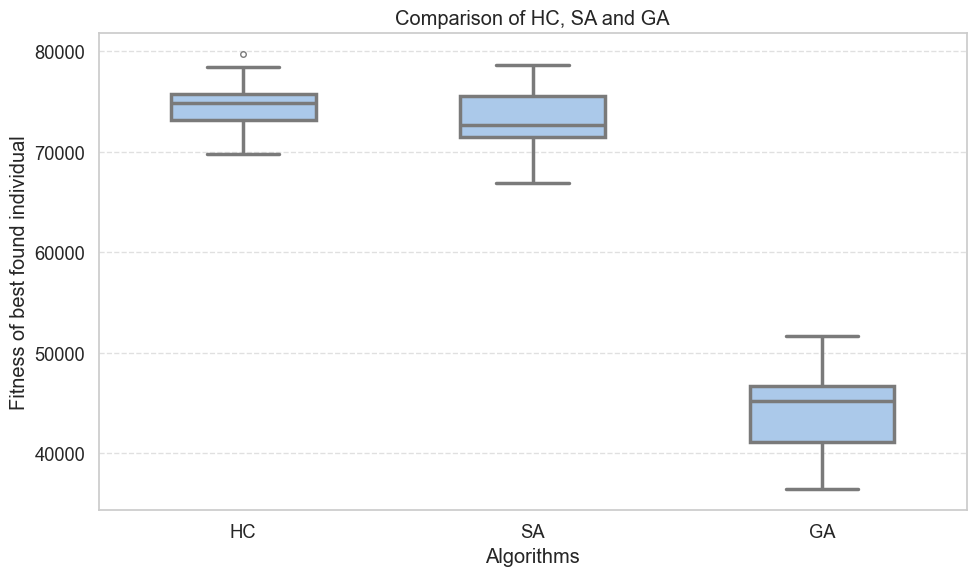

In [ ]:
# Create a DataFrame in long format
df = pd.DataFrame({
    'value': hc_best_fitnesses + sa_best_fitnesses + ga_best_fitnesses,
    'group': ['HC'] * len(hc_best_fitnesses) + ['SA'] * len(sa_best_fitnesses) + ['GA'] * len(ga_best_fitnesses)
})

# Set a beautiful theme
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='group', y='value', data=df, width=0.5, linewidth=2.5, fliersize=4)

# Titles and labels
plt.title('Comparison of HC, SA and GA')
plt.xlabel('Algorithms')
plt.ylabel('Fitness of best found individual')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()